# Decision Tree Model

In [38]:
# decision tree model
import math
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
def entropy_func(c, n):
    return -(c*1.0/n)*math.log(c*1.0/n, 2)

def entropy_cal(c1, c2):
    #entropy between class 1 and 2
    if c1== 0 or c2 == 0:  # when there is only one class in the group, entropy is 0
        return 0
    return entropy_func(c1, c1+c2) + entropy_func(c2, c1+c2)

# One versus All
# c1,c2,c3, .., cm
# c1, *
# c2, *
# c3, *
# ...
# cm, *

#each class versus the others
def entropy_of_one_division(division): 
    s = 0
    n = len(division)
    classes = set(division)
    for c in classes:   # for each class, get entropy
        n_c = sum(division==c)
        e = n_c*1.0/n * entropy_cal(sum(division==c), sum(division!=c)) # weighted avg
        s += e
    return s, n

# The whole entropy
def get_entropy(y_predict, y_real):
    if len(y_predict) != len(y_real):
        print('They have to be the same length')
        return None
    n = len(y_real)
    s_true, n_true = entropy_of_one_division(y_real[y_predict]) # left hand side entropy
    s_false, n_false = entropy_of_one_division(y_real[~y_predict]) # right hand side entropy
    s = n_true*1.0/n * s_true + n_false*1.0/n * s_false # overall entropy, again weighted average
    return s

In [36]:
class DecisionTreeClassifier(object):
    def __init__(self, max_depth):
        self.depth = 0
        self.max_depth = max_depth


    def get_params(self, deep=True):
        return {"max_depth": self.max_depth}
    
    def set_params(self, **params):
        for parameter, value in params.items():
            setattr(self, parameter, value)
        return self
    
    def fit(self, x, y, par_node={}, depth=0):
        if par_node is None: 
            return None
        elif len(y) == 0:
            return None
        elif self.all_same(y):
            return {'val':y[0]}
        elif depth >= self.max_depth:
            return None
        else: 
            col, cutoff, entropy = self.find_best_split_of_all(x, y)    # find one split given an information gain 
            y_left = y[x[:, col] < cutoff]
            y_right = y[x[:, col] >= cutoff]
            par_node = {'col': features[col], 'index_col':col,
                        'cutoff':cutoff,
                       'val': np.round(np.mean(y))}
            par_node['left'] = self.fit(x[x[:, col] < cutoff], y_left, {}, depth+1)
            par_node['right'] = self.fit(x[x[:, col] >= cutoff], y_right, {}, depth+1)
            self.depth += 1 
            self.trees = par_node
            return par_node
    
    #all features versus values, get best
    def find_best_split_of_all(self, x, y):
        #print(x.shape, y.shape)
        col = None
        min_entropy = 1
        cutoff = None
        for i, c in enumerate(x.T):
            entropy, cur_cutoff = self.find_best_split(c, y)
            if entropy == 0:    # find the first perfect cutoff. Stop Iterating
                return i, cur_cutoff, entropy
            elif entropy <= min_entropy:
                min_entropy = entropy
                col = i
                cutoff = cur_cutoff
        return col, cutoff, min_entropy
    
    #one feature versus values
    def find_best_split(self, col, y):
        min_entropy = 10
        n = len(y)
        for value in set(col):
            y_predict = col < value #get which ones are less than
            my_entropy = get_entropy(y_predict, y)
            if my_entropy <= min_entropy:
                min_entropy = my_entropy
                cutoff = value
        return min_entropy, cutoff
    
    def all_same(self, items):
        return all(x == items[0] for x in items)
                                           
    def predict(self, x):
        tree = self.trees
        results = np.array([0]*len(x))
        for i, c in enumerate(x):
            results[i] = self._get_prediction(c)
        return results
    
    def _get_prediction(self, row):
        cur_layer = self.trees
        while cur_layer.get('cutoff'):
            if row[cur_layer['index_col']] < cur_layer['cutoff']:
                cur_layer = cur_layer['left']
            else:
                cur_layer = cur_layer['right']
        else:
            return cur_layer.get('val')
    
    def score(self, y_pred, y_test):        
        return float(sum(y_pred == y_test))/ float(len(y_test))
        
    def accurancy(self, y_pred, y_test):
        return accuracy_score(y_test, y_pred)
    
    def precision(self, y_pred,y_test):
        return precision_score(y_test, y_pred)
    
    def recall(self, y_pred,y_test):
        return recall_score(y_test, y_pred)
    
    def auc(self, y_pred,y_test):
        auc = roc_auc_score(y_test, y_pred)
        return auc
    
    def plot_roc(self, y_pred,y_test):
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        # graficar la curva ROC
        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de falsos positivos')
        plt.ylabel('Tasa de verdaderos positivos')
        plt.title('Curva ROC para un modelo de Arboles de decision')
        plt.show()

## Load Cancer dataset


In [22]:

# read the dataset
df_cancer = pd.read_csv('datasets/Cancer_Data.csv')

# make sure that there are no null values that can affect the models
mask = df_cancer.isnull()
#print(mask.sum())

# delete unnecesary or null columns
df_cancer = df_cancer.drop(columns=['id', 'Unnamed: 32'])

# visualizing the values of each feature and the comparison to the output
#for col in df_cancer.columns[:-1]:
#    df_cancer.plot(x=col, y='diagnosis', kind='scatter', figsize=(8, 5))
#plt.show()

df_cancer.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [23]:
"""
Data preprocessing - outlier treatment
eliminating items from outside from of the 
1.5 * Inter Quartile Range (0.125% to 0.875% of the data)
"""
l_limit_perc = 0
h_limit_perc = 0.99

for column in df_cancer.columns:
    if column == 'diagnosis': 
        continue
    low_limit = df_cancer[column].quantile(l_limit_perc)
    high_limit = df_cancer[column].quantile(h_limit_perc)
    df_cancer = df_cancer.loc[(df_cancer[column] >= low_limit) & (df_cancer[column] <= high_limit)]

#print(df_cancer.count())

# visualizing the values of each feature and the comparison to the output
#for col in df_cancer.columns[:-1]:
#    df_cancer.plot(x=col, y='diagnosis', kind='scatter', figsize=(8, 5))
#plt.show()

In [24]:
# feature engineering
#Normalizing the dataset
for column in df_cancer.columns:
    if column == 'diagnosis': 
        continue
    df_cancer[column] = (df_cancer[column]-df_cancer[column].mean())/df_cancer[column].std()


# change value of output to 0 and 1
# 0 -> B
# 1 -> M
df_cancer.loc[df_cancer['diagnosis'] == 'B', 'diagnosis'] = 0
df_cancer.loc[df_cancer['diagnosis'] == 'M', 'diagnosis'] = 1
features = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']

#Split the data set between the targets
X0 = df_cancer.loc[df_cancer['diagnosis'] == 0, features]
Y0 = df_cancer.loc[df_cancer['diagnosis'] == 0, 'diagnosis']

X1 = df_cancer.loc[df_cancer['diagnosis'] == 1, features]
Y1 = df_cancer.loc[df_cancer['diagnosis'] == 1, 'diagnosis']

#print(df_cancer)



El accuracy fue de: 0.9146341463414634
La precision fue de: 0.8529411764705882
El recall fue de: 0.9146341463414634
La auc fue de: 0.8617376775271512
La curva ROC es la siguiente:


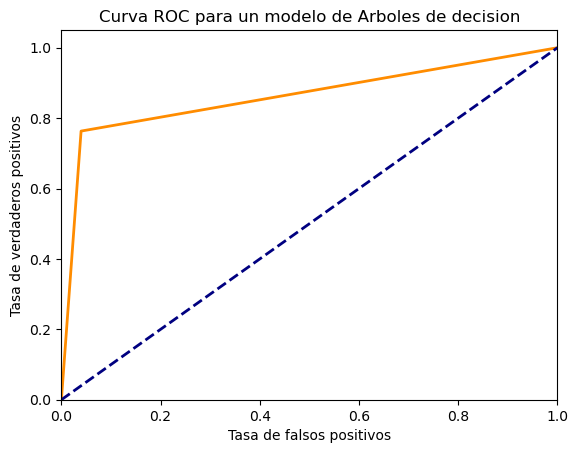

In [39]:
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, Y0, test_size=0.4, random_state=40)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.4, random_state=40)

X_train = (pd.concat([X0_train, X1_train], axis= 0)).values
y_train = (pd.concat([y0_train, y1_train], axis= 0)).values
X_test = (pd.concat([X0_test, X1_test], axis= 0)).values
y_test = ((pd.concat([y0_test, y1_test], axis= 0)).values).astype(int)




model = DecisionTreeClassifier(max_depth=10)
#skmodel =  DecisionTreeClassifier(max_depth=10)

#skmodel.fit(X_train,y_train)

model.fit(X_train, y_train)

y_pred = model.predict(X_test).astype(int)



accuracy = model.accurancy(y_pred,y_test)
presicion = model.precision(y_pred,y_test)
recall = model.recall(y_pred,y_test)
auc = model.auc(y_pred,y_test)


print('El accuracy fue de:',accuracy)
print('La precision fue de:',presicion)
print('El recall fue de:',accuracy)
print('La auc fue de:',auc)

print('La curva ROC es la siguiente:')
model.plot_roc(y_pred,y_test)




